In [1]:
from utils import read_evs_h5
import numpy as np
import matplotlib.pyplot as plt

ev_path = "ori_data/ShakeCarpet1/events/events.h5"
linked_path = "ShakeCarpet1_formatted/ecam_set/linked_events.npy"

In [2]:
def get_chain(l_evs, tx, ty):
    xs, ys = l_evs["x"], l_evs["y"]
    cond = (xs == tx) & (ys == ty)
    st_idx = cond.argmax()

    curr_ev = l_evs[st_idx]
    chain_evs = [curr_ev]

    while True:
        curr_ev = l_evs[curr_ev["next_idx"]]
        chain_evs.append(curr_ev)

        if curr_ev["next_idx"] == -1:
            break
    return np.stack(chain_evs)

def is_same(ori_evs, chain_evs):
    res = 0
    for k in "xytp":
        res += (ori_evs[k] - chain_evs[k]).sum()
    
    return res == 0

def get_ev_idx(evs, x, y, t):
    xs, ys, ts = [evs[e] for e in "xyt"]
    cond = (xs == x) & (ys == y) & (ts == t)
    return cond.argmax()

In [3]:
ori_evs = read_evs_h5(ev_path)
cond = ori_evs["p"] == 0
ori_evs["p"] = ori_evs["p"].astype(np.int8)
ori_evs["p"][cond] = -1


l_evs = np.load(linked_path)

loading hdf5


In [4]:
def get_ori(idx):
    return {"x":ori_evs["x"][idx],
            "y":ori_evs["y"][idx],
            "t":ori_evs["t"][idx],
            "p":ori_evs["p"][idx],}

def get_interval_p(st, end, x, y):
    xs, ys, ts = ori_evs['x'], ori_evs['y'], ori_evs["t"]

    t_cond = (ts >= st) & (ts <= end)
    loc_cond = (x == xs) & (ys == y)
    cond = t_cond & loc_cond
    print("n t_cond:", t_cond.sum())
    print("n loc_cond:", loc_cond.sum())
    print("num evs:", cond.sum())
    p_val = ori_evs["p"][cond].sum()

    print("p val:", p_val)
    return p_val


def eimg2rgb(eimg):
    img = np.zeros((*eimg.shape, 3))
    pos_cond = eimg > 0
    neg_cond = eimg < 0
    img[pos_cond, 1] = 255
    img[neg_cond, 0] = 255
    return img.astype(np.uint8)


def create_eimg(st, end, ret_img = True, xc=None, yc=None):
    h, w, c = (360, 480, 3)
    e_img = np.zeros((h, w))
    x, y, p, t = ori_evs["x"], ori_evs["y"], ori_evs["p"], ori_evs["t"]

    cond = (t > st) & (t <= end)

    pos_p = (p == 1) & cond
    neg_p = (p == -1) & cond
    np.add.at(e_img, (y[pos_p], x[pos_p]), 1)
    np.add.at(e_img, (y[neg_p], x[neg_p]), -1)

    if xc:
        y_sub = y[cond]
        x_sub = x[cond]
        print("loc cnt:", ((x_sub == xc) & (y_sub == yc)).sum())

    if ret_img:
        return e_img, eimg2rgb(e_img)
    else:
        return e_img
    

In [5]:
st, end = (24793, 34396)
x, y = [180, 240]
get_interval_p(st, end, x, y)

n t_cond: 1917334
n loc_cond: 1573
num evs: 6
p val: 6


6

loc cnt: 5
pval 5.0


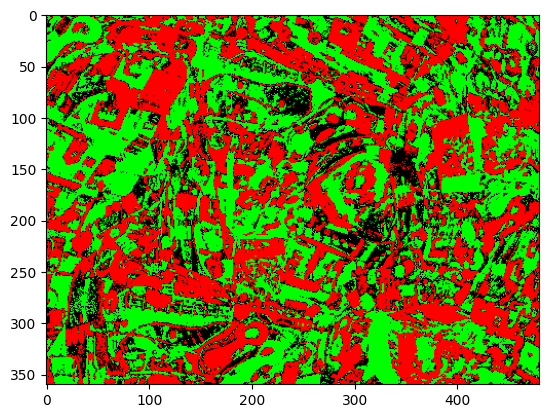

In [6]:
cnt, rgb = create_eimg(st, end, xc=x, yc=y)
print("pval", cnt[y, x])
plt.imshow(rgb)